In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time

%matplotlib inline

In [2]:
data = pd.read_csv('data/train.csv')
acd = data['acoustic_data'].values
ttf = data['time_to_failure'].values
del data
n = acd.shape[0]
print('{} rows of data (time steps)'.format(n))

629145480 rows of data (time steps)


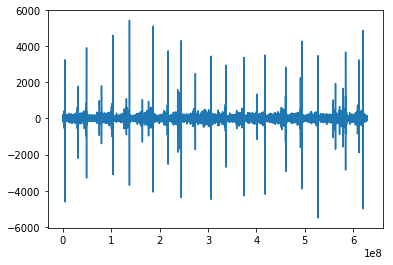

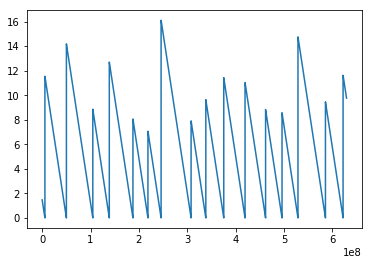

In [3]:
plt.plot(acd)
plt.show()

plt.plot(ttf)
plt.show()


In [5]:
n_layers = 10


class ResBlock(nn.Module):
    def __init__(self, num_layer, num_channels):
        super(ResBlock, self).__init__()
        self.dilation = 2 ** (n_layers - num_layer - 1)
        self.dilated = nn.Conv1d(out_channels=num_channels,
                                 in_channels=num_channels,
                                 kernel_size=2,
                                 padding=self.dilation,
                                 dilation=self.dilation)
        self.one_by_one = nn.Conv1d(out_channels=num_channels,
                                    in_channels=num_channels,
                                    kernel_size=1,
                                    dilation=1)
        self.tanh, self.sigmoid = nn.Tanh(), nn.Sigmoid()

    def forward(self, x):
        old_x = x
        x = self.dilated(x)
        x = self.tanh(x) * self.sigmoid(x)
        x = self.one_by_one(x)
        x = x[:, :, :-self.dilation]  # crop off excess from padding
        return old_x + x, x  # residual, skip

    
class TheBoi(nn.Module):
    def __init__(self, num_channels, use_skip_connections=True):
        super(TheBoi, self).__init__()
        self.input_layer = nn.Conv1d(out_channels=num_channels,
                                     in_channels=num_channels,
                                     kernel_size=2,
                                     padding=1,
                                     dilation=1)
        
        self.blocks = nn.ModuleList(
            [ResBlock(layer_len, num_channels) for layer_len in reversed(range(n_layers - 1))]
        )
        
        self.output_chain = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(out_channels=num_channels,
                      in_channels=num_channels,
                      kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(out_channels=num_channels,
                      in_channels=num_channels,
                      kernel_size=1),
            nn.Softmax(dim=1)
        )
        
        self.num_channels = num_channels
        self.use_skip_connections = use_skip_connections
    
    def forward(self, x):
        skip_connections = []
        x = self.input_layer(x)[:,:,:-1]  # crop off excess from padding
        for res_block in self.blocks:
            x, skip = res_block(x)
            skip_connections.append(skip)
        # print(skip_connections)
        if self.use_skip_connections:
            x = torch.zeros(x.shape)
            for skip in skip_connections:
                x = x + skip
        x = self.output_chain(x)
        return x


def miu_law(d, miu=255):
    # scale -1 < d < 1
    a = np.abs(d)
    m = np.max(a) + 1
    d = d / m
    # apply miu law
    d = np.where(d < 0, -1, 1) * np.log(1 + miu*a)/np.log(1 + miu)
    del a
    return d, m  # m returned for reconstruction

def linear_quantization(d, groups=256):
    r = (np.min(d), np.max(d))
    b = (r[1] - r[0])/groups
    bins = [r[0] + b*i for i in range(1, groups)]
    d = np.digitize(d, bins)
    del bins
    return d, r  # range returned for reconstruction

# def index_to_onehot_tensor(x, d, grps):
#     x.zero_()
#     for i, j in zip(range(d.shape[0]), d):
#         new_d[i, j] = 1
#     return new_d.t().view(1, grps, -1)


In [4]:
# quantize data
num_groups = 256
num_objects = 275941
obj_length = n // num_objects

acd, _ = miu_law(acd, miu=num_groups-1)
acd, _ = linear_quantization(acd, groups=num_groups)

ttf, rrange = linear_quantization(ttf, groups=num_groups)
rrange

(9.550396316600001e-05, 16.1074)

In [3]:
# training
model = TheBoi(num_groups)
loss_fn = nn.MSELoss(reduction='sum')
learning_rate = 1e-6
optimizer = optim.Adam(model.parameters(recurse=True), lr=learning_rate)


batch_size = 112
num_batches = num_objects // batch_size  # round off last batch (size != batch_size)

x = torch.zeros((batch_size, num_groups, obj_length))
z = torch.zeros((batch_size, num_groups, obj_length))
ix = np.arange(num_objects)
orig_start = time.time()
for epoch in range(1):
    np.random.shuffle(ix)
    acd = acd[ix]
    ttf = ttf[ix]
    batch = 0
    while batch < num_batches:
        start = time.time()
        r = (batch_size * batch, batch_size * (batch + 1))
        batch += 1
        
        # setting x to input...
        x.zero_()
        x.scatter_(1, torch.LongTensor(acd[r[0]:r[1]]).view(batch_size, 1, obj_length), 1)
        
        # setting z to true values...
        z.zero_()
        z.scatter_(1, torch.LongTensor(ttf[r[0]:r[1]]).view(batch_size, 1, obj_length), 1)

        optimizer.zero_grad()

        # running through model...
        y = model(x)
        
        loss = loss_fn(z, y)
        print('epoch {}, batch {}, loss = {}'.format(epoch + 1, batch, loss.item()))
        
        loss.backward()
        optimizer.step()

        end = time.time()
        print('({} batches left, last batch took {:.2f} min)'.format(num_batches - batch - 1, (end - start)/60))

torch.save(model, 'wavenet.pt')

torch.Size([1, 256, 275941])

In [ ]:
# test dimensions of output
x = torch.rand((1, 256, 275941))
y = model(x)
y.shape

In [7]:
# classification 

filenames = []
for _, _, files in os.walk('data/test/'):
    filenames.extend(files)

s = {'seg_id': [fname[:-4] for fname in sorted(filenames)], 'time_to_failure': []}

model = torch.load('wavenet.pt')

receptive_field = 2 ** n_layers
num_groups = 256

rrange = (9.550396316600001e-05, 16.1074)

x = torch.zeros((1, num_groups, receptive_field))
for i, fname in enumerate(sorted(filenames)):
    data = pd.read_csv('data/test/' + fname)
    acd = data['acoustic_data'].values
    acd = acd[-receptive_field:]
    
    acd, _ = miu_law(acd, miu=num_groups-1)
    acd, _ = linear_quantization(acd, groups=num_groups)
    
    x.zero_()
    x.scatter_(1, torch.LongTensor(acd).view(1, 1, -1), 1)
    
    y = model(x)
    y = np.argmax(x, axis=1)[0][-1].item()
    
    y = (rrange[1] - rrange[0]) * (y / (num_groups - 1)) + rrange[0]
    s['time_to_failure'].append(y)
    
    print(i, y)


0 15.159911500233125
1 14.591418400373003
2 15.223077400217583
3 15.72840460009325
4 14.907247900295294
5 14.149257100481796
6 15.03357970026421
7 14.27558890045071
8 15.223077400217583
9 2.9688928032326998
10 14.591418400373003
11 15.3494092001865
12 14.970413800279752
13 13.454432200652755
14 14.338754800435169
15 13.454432200652755
16 14.844082000310834
17 15.159911500233125
18 15.41257510017096
19 13.391266300668297
20 15.72840460009325
21 7.5168376021136885
22 15.223077400217583
23 13.770261700575047
24 15.475741000155416
25 15.602072800124333
26 13.833427600559503
27 15.223077400217583
28 9.550396316600001e-05
29 14.465086600404087
30 15.223077400217583
31 15.538906900139875
32 14.970413800279752
33 15.096745600248667
34 15.602072800124333
35 15.03357970026421
36 13.959759400528421
37 14.465086600404087
38 14.844082000310834
39 14.780916100326376
40 15.665238700108791
41 15.475741000155416
42 15.41257510017096
43 14.65458430035746
44 15.72840460009325
45 1.2634135036523293
46 1.4

In [8]:
df = pd.DataFrame(s)
df.head()
df.to_csv('submission.csv')

,seg_id,time_to_failure
0,seg_00030f,15.159912
1,seg_0012b5,14.591418
2,seg_00184e,15.223077
3,seg_003339,15.728405
4,seg_0042cc,14.907248
